In [9]:
import gymnasium as gym
import torch
from torch.utils.tensorboard import SummaryWriter
import tianshou as ts
from tianshou.data import CollectStats
from tianshou.utils.space_info import SpaceInfo
import argparse
import os
import pickle

import gymnasium as gym
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter

from tianshou.data import (
    Collector,
    CollectStats,
    PrioritizedVectorReplayBuffer,
    VectorReplayBuffer,
)
import baird
import boyan
import RandomWalk
from tianshou.env import DummyVectorEnv
from tianshou.policy import RainbowPolicy
from tianshou.policy.base import BasePolicy
from tianshou.policy.modelfree.rainbow import RainbowTrainingStats
import tianshou.policy.modelfree.rainbow as rainbow
from tianshou.trainer import OffpolicyTrainer
from tianshou.utils import TensorboardLogger
from tianshou.utils.net.common import Net
from tianshou.utils.net.discrete import NoisyLinear
from tianshou.utils.space_info import SpaceInfo

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
envs_names = ["BairdsCounterexample-v0", "BoyanChain", "RandomWalk"]
reward_threshholds = [10, 500, 500]
def get_args(env_idx) -> argparse.Namespace:
    parser = argparse.ArgumentParser()
    parser.add_argument("--task", type=str, default=envs_names[env_idx])
    parser.add_argument("--reward-threshold", type=float, default=reward_threshholds[env_idx])
    parser.add_argument("--seed", type=int, default=1626)
    parser.add_argument("--eps-test", type=float, default=0.05)
    parser.add_argument("--eps-train", type=float, default=0.1)
    parser.add_argument("--buffer-size", type=int, default=20000)
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--gamma", type=float, default=0.9)
    parser.add_argument("--num-atoms", type=int, default=51)
    parser.add_argument("--v-min", type=float, default=-10.0)
    parser.add_argument("--v-max", type=float, default=10.0)
    parser.add_argument("--noisy-std", type=float, default=0.1)
    parser.add_argument("--n-step", type=int, default=3)
    parser.add_argument("--target-update-freq", type=int, default=320)
    parser.add_argument("--epoch", type=int, default=2)
    parser.add_argument("--step-per-epoch", type=int, default=8000)
    parser.add_argument("--step-per-collect", type=int, default=8)
    parser.add_argument("--update-per-step", type=float, default=0.125)
    parser.add_argument("--batch-size", type=int, default=64)
    parser.add_argument("--hidden-sizes", type=int, nargs="*", default=[128, 128, 128, 128])
    parser.add_argument("--training-num", type=int, default=8)
    parser.add_argument("--test-num", type=int, default=100)
    parser.add_argument("--logdir", type=str, default="log")
    parser.add_argument("--render", type=float, default=0.0)
    parser.add_argument("--prioritized-replay", action="store_true", default=False)
    parser.add_argument("--alpha", type=float, default=0.6)
    parser.add_argument("--beta", type=float, default=0.4)
    parser.add_argument("--beta-final", type=float, default=1.0)
    parser.add_argument("--resume", action="store_true", default=False)
    parser.add_argument(
        "--device",
        type=str,
        default="cuda" if torch.cuda.is_available() else "cpu",
    )
    parser.add_argument("--save-interval", type=int, default=4)
    return parser.parse_known_args()[0]



In [11]:
def train(env_idx):
    rainbow.RESULTS = []
    args: argparse.Namespace = get_args(env_idx)
    env = gym.make(args.task)
    assert isinstance(env.action_space, gym.spaces.Discrete)
    space_info = SpaceInfo.from_env(env)
    args.state_shape = space_info.observation_info.obs_shape
    args.action_shape = space_info.action_info.action_shape
    if args.reward_threshold is None:
        default_reward_threshold = {"BoyanChain": 200}
        args.reward_threshold = default_reward_threshold.get(
            args.task,
            env.spec.reward_threshold if env.spec else None,
        )
    # train_envs = gym.make(args.task)
    # you can also use tianshou.env.SubprocVectorEnv
    train_envs = DummyVectorEnv([lambda: gym.make(args.task) for _ in range(args.training_num)])
    # test_envs = gym.make(args.task)
    test_envs = DummyVectorEnv([lambda: gym.make(args.task) for _ in range(args.test_num)])
    # seed
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    train_envs.seed(args.seed)
    test_envs.seed(args.seed)
    # model
    def noisy_linear(x: int, y: int) -> NoisyLinear:
        return NoisyLinear(x, y, args.noisy_std)
    net = Net(
        state_shape=args.state_shape,
        action_shape=args.action_shape,
        hidden_sizes=args.hidden_sizes,
        device=args.device,
        softmax=True,
        num_atoms=args.num_atoms,
        dueling_param=({"linear_layer": noisy_linear}, {"linear_layer": noisy_linear}),
    )
    optim = torch.optim.Adam(net.parameters(), lr=args.lr)
    policy: RainbowPolicy[RainbowTrainingStats] = RainbowPolicy(
    model=net,
    optim=optim,
    discount_factor=args.gamma,
    action_space=env.action_space,
    num_atoms=args.num_atoms,
    v_min=args.v_min,
    v_max=args.v_max,
    estimation_step=args.n_step,
    target_update_freq=args.target_update_freq,
    ).to(args.device)
    # buffer
    buf: PrioritizedVectorReplayBuffer | VectorReplayBuffer
    if args.prioritized_replay:
        buf = PrioritizedVectorReplayBuffer(
            args.buffer_size,
            buffer_num=len(train_envs),
            alpha=args.alpha,
            beta=args.beta,
            weight_norm=True,
        )
    else:
        buf = VectorReplayBuffer(args.buffer_size, buffer_num=len(train_envs))
    # collector
    train_collector = Collector[CollectStats](policy, train_envs, buf, exploration_noise=True)
    test_collector = Collector[CollectStats](policy, test_envs, exploration_noise=True)
    # policy.set_eps(1)
    train_collector.reset()
    train_collector.collect(n_step=args.batch_size * args.training_num)
    
    # log
    log_path = os.path.join(args.logdir, args.task, "rainbow")
    writer = SummaryWriter(log_path)
    logger = TensorboardLogger(writer, save_interval=args.save_interval)
    def save_best_fn(policy: BasePolicy) -> None:
        torch.save(policy.state_dict(), os.path.join(log_path, "policy.pth"))
    def stop_fn(mean_rewards: float) -> bool:
        return mean_rewards >= args.reward_threshold
    def train_fn(epoch: int, env_step: int) -> None:
        # eps annealing, just a demo
        if env_step <= 10000:
            policy.set_eps(args.eps_train)
        elif env_step <= 50000:
            eps = args.eps_train - (env_step - 10000) / 40000 * (0.9 * args.eps_train)
            policy.set_eps(eps)
        else:
            policy.set_eps(0.1 * args.eps_train)
        # beta annealing, just a demo
        if args.prioritized_replay:
            if env_step <= 10000:
                beta = args.beta
            elif env_step <= 50000:
                beta = args.beta - (env_step - 10000) / 40000 * (args.beta - args.beta_final)
            else:
                beta = args.beta_final
            buf.set_beta(beta)
    def test_fn(epoch: int, env_step: int | None) -> None:
        policy.set_eps(args.eps_test)
    
        # trainer
    result = OffpolicyTrainer(
        policy=policy,
        train_collector=train_collector,
        test_collector=test_collector,
        max_epoch=args.epoch,
        step_per_epoch=args.step_per_epoch,
        step_per_collect=args.step_per_collect,
        episode_per_test=args.test_num,
        batch_size=args.batch_size,
        update_per_step=args.update_per_step,
        train_fn=train_fn,
        test_fn=test_fn,
        stop_fn=stop_fn,
        logger=logger,
        resume_from_log=args.resume,
    ).run()
    return rainbow.RESULTS.copy()


In [12]:
results = []
for i in range(len(envs_names)):
    results.append(train(i))

                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #1: test_reward: 0.000000 ± 0.000000, best_reward: 0.000000 ± 0.000000 in #0


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
      

Epoch #2: test_reward: 0.000000 ± 0.000000, best_reward: 0.000000 ± 0.000000 in #0


c:\Users\m4mou\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\envs\registration.py:531: UserWarning: WARN: Using the latest versioned environment `BoyanChain-v0` instead of the unversioned environment `BoyanChain`.
  logger.warn(
c:\Users\m4mou\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\utils\passive_env_checker.py:160: UserWarning: WARN: The obs returned by the `step()` method was expecting a numpy array, actual type: <class 'tuple'>
  logger.warn(
c:\Users\m4mou\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\spaces\box.py:230: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
          

Epoch #1: test_reward: -41.460000 ± 99.563288, best_reward: -41.460000 ± 99.563288 in #1


                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
Epoch #2: 8001it [00:32, 248.20it/s, env_episode=1708, env_step=16000, gradient_step=2000, len=12, n/ep=1, n/st=8, rew=-32.00]                          


Epoch #2: test_reward: -98.530000 ± 254.966878, best_reward: -41.460000 ± 99.563288 in #1


c:\Users\m4mou\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\envs\registration.py:531: UserWarning: WARN: Using the latest versioned environment `RandomWalk-v0` instead of the unversioned environment `RandomWalk`.
  logger.warn(
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                       

Epoch #1: test_reward: 1.000000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #1



                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
                                                                Collect time is 0, setting collect speed to 0. Did you make a rounding error?
     

Epoch #2: test_reward: 1.000000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #1


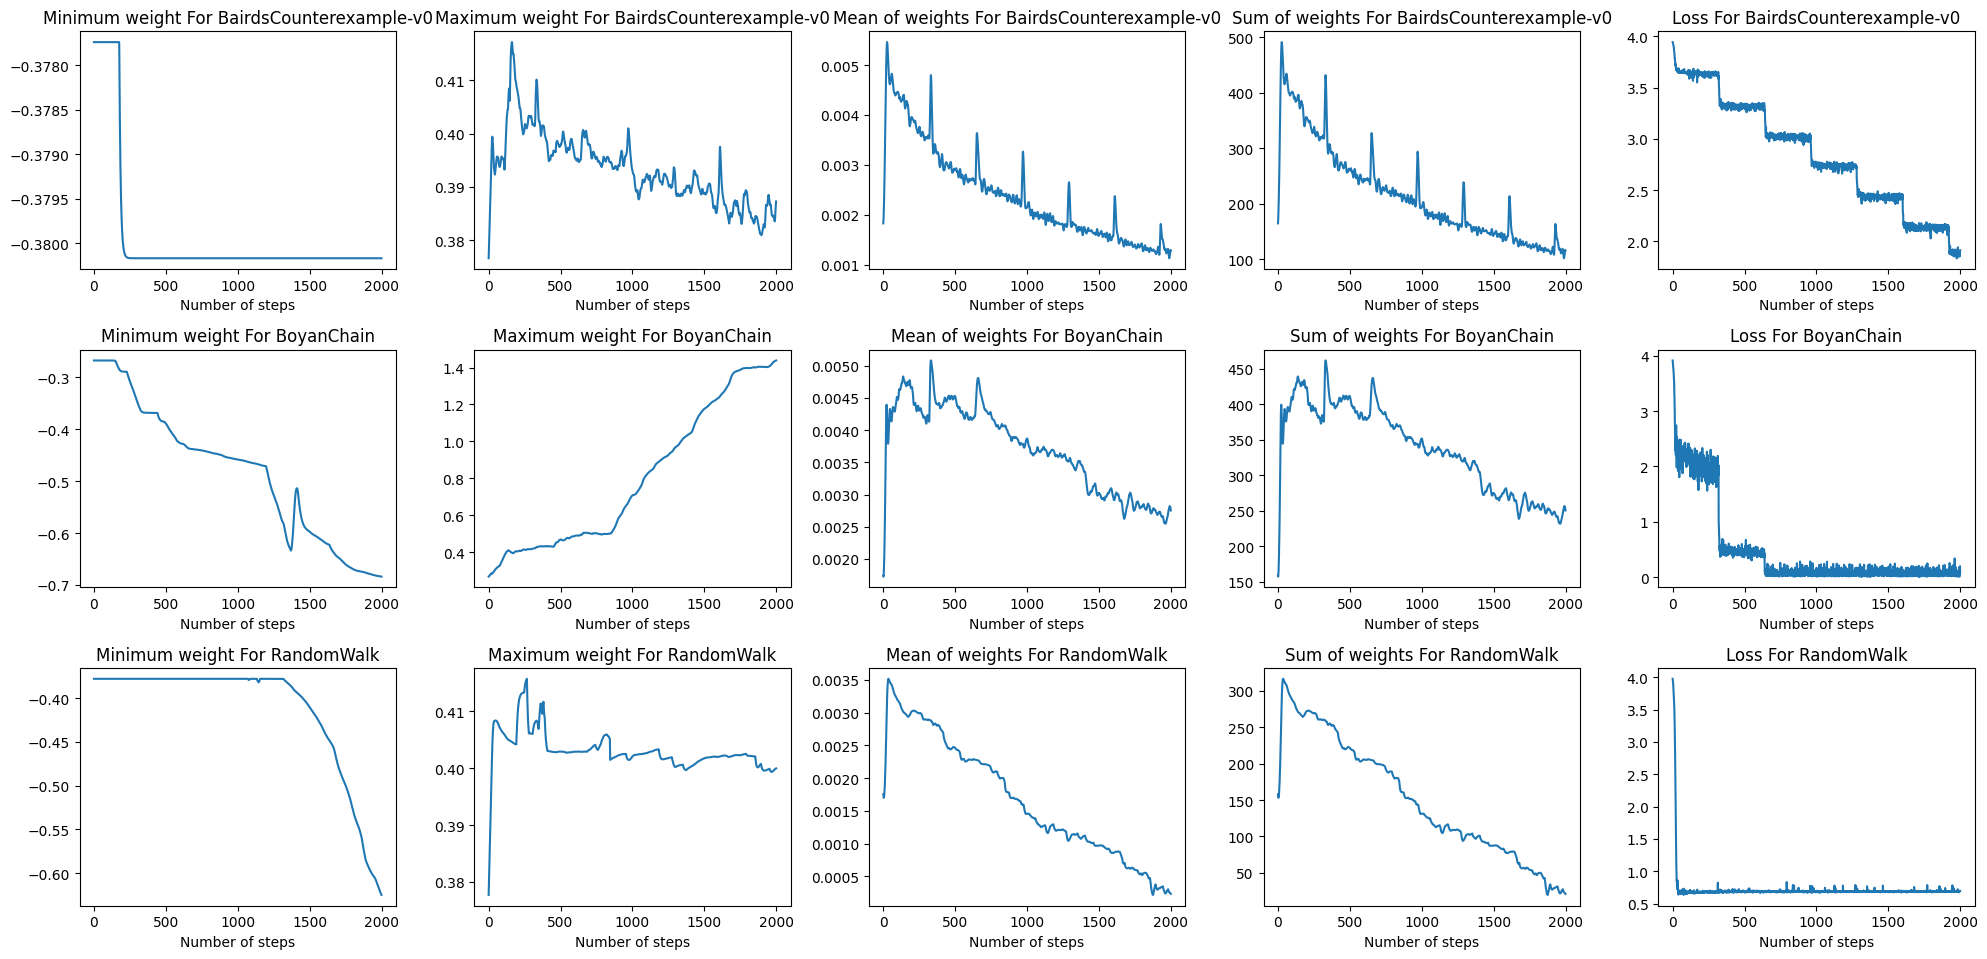

In [13]:
import matplotlib.pyplot as plt
import numpy as np
def plot_3x5_subplots(results, labels=None):
    """
    Plot a 3x5 grid of subplots using data from a 3D array.

    Parameters:
    - results: 3x5 list/array where results[i][j] contains (x, y1, y2, ..., yn) data for subplot[i][j]
    - titles: Optional 3x5 list of titles for each subplot
    - labels: Optional list of labels for each line in the plots (used in legends per column)
    """

    fig, axes = plt.subplots(3, 5, figsize=(20, 10), sharex=False, sharey=False)

    for i in range(3):
        data = results[i]
        data = np.array(data).T
        for j in range(5):
            ax = axes[i][j]
            
            ax.plot(data[j], label=labels[j])

            title = labels[j] + " For " + envs_names[i]
            ax.set_title(title)
            ax.set_xlabel("Number of steps")


    # # Add shared legends per column
    # for j in range(5):
    #     handles, legend_labels = axes[0][j].get_legend_handles_labels()
    #     if handles:
    #         fig.legend(handles, legend_labels, loc='upper center', ncol=len(legend_labels), bbox_to_anchor=(0.1 + j * 0.18, 1.03))

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Line labels
labels = ["Minimum weight", "Maximum weight", "Mean of weights", "Sum of weights", "Loss"]

plot_3x5_subplots(results, labels)